# Learning Uncertainty Sets

In [1]:
import cvxpy as cp
import scipy as sc
import numpy as np
import numpy.random as npr
import torch
from sklearn import datasets
import pandas as pd
import lropt
import sys
sys.path.append('..')
from utils import plot_iters, plot_coverage_all
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from mpl_toolkits.axes_grid1.inset_locator import mark_inset, zoomed_inset_axes
import warnings
warnings.filterwarnings("ignore")

### Example 4: Portfolio management


In [2]:
n = 8
seed = 15
np.random.seed(seed)
dist = (np.array([25, 10, 60, 50, 40, 30, 30, 20,
                20, 15, 10, 10, 10, 10, 10, 10])/10)[:n]
y_data = np.random.dirichlet(dist, 10)

In [3]:
def gen_demand(n, N, seed=399):
    np.random.seed(seed)
    F = np.random.normal(size = (n,2))
    # sig = np.random.uniform(0,0.9,(n,n))
    sig = 0.1*F@(F.T)
    mu = np.random.uniform(0.5,1,n)
    d_train = np.random.multivariate_normal(mu,sig, N)
    return d_train

def f_tch(t, x, y, u):
    # x is a tensor that represents the cp.Variable x.
    return t + 0.2*torch.linalg.vector_norm(x-y, 1)

def g_tch(t, x, y, u):
    # x,y,u are tensors that represent the cp.Variable x and cp.Parameter y and u.
    # The cp.Constant c is converted to a tensor
    return -x @ u.T - t

def eval_tch(t, x, y, u):
    return -x @ u.T + 0.2*torch.linalg.vector_norm(x-y, 1)

data = gen_demand(n,600, seed=1)

# data = gen_demand(n, 600, seed=15)
# import pandas as pd
# import yfinance as yf

# stocks = ['JPM', 'AMZN', 'TSLA', 'AAPL', 'GOOG', 'ZM', 'META', 'MCD']
# start = '2021-1-2'              # starting date of historical data
# end='2021-12-31'                # end date of historical data

# ydata = pd.DataFrame([])
# for stock in stocks:
#     each = yf.Ticker(stock).history(start=start, end=end)
#     close = each['Close'].values
#     returns = (close[1:] - close[:-1]) / close[:-1]
#     ydata[stock] = returns
# data = ydata.values[:,:2]*10


In [10]:
u = lropt.UncertainParameter(n,
                        uncertainty_set=lropt.Ellipsoidal(p=2,
                                                    data=data))
# Formulate the Robust Problem
x = cp.Variable(n)
t = cp.Variable()
y = lropt.Parameter(n, data=y_data)

objective = cp.Minimize(t + 0.2*cp.norm(x - y, 1))
constraints = [-x@u.T <= t, cp.sum(x) == 1, x >= 0]

prob = lropt.RobustProblem(objective, constraints, objective_torch=f_tch, constraints_torch=[g_tch], eval_torch=eval_tch)
test_p = 0.1
s = 5
train, test = train_test_split(data, test_size=int(
    data.shape[0]*test_p), random_state=s)
init = np.real(sc.linalg.sqrtm(sc.linalg.inv(np.cov(train.T))))
init_bval = -init@np.mean(train, axis=0)
np.random.seed(15)
initn = np.random.rand(n, n) + 0.1*init + 0.5*np.eye(n)
init_bvaln = -initn@(np.mean(train, axis=0) - 0.3*np.ones(n))
# Train A and b
result = prob.train(lr=0.015, num_iter=3000, optimizer="SGD",
                    seed=s, init_A=initn, init_b=init_bvaln, init_lam=0.5, init_mu=0.01,
                    mu_multiplier=1.001, init_alpha=0., test_percentage = test_p, save_history = True, lr_step_size = 500, lr_gamma = 0.2, position = False, random_init = True, num_random_init=5, parallel = True)
df = result.df
A_fin = result.A
b_fin = result.b

run 3: test value -0.474, violations 0.033: 100%|██████████| 3000/3000 [04:13<00:00, 11.84it/s]


In [11]:
# # Grid search epsilon
# init = np.real(sc.linalg.sqrtm(sc.linalg.inv(np.cov(train.T)))) + 0.1*np.eye(n)
# init_bval = -init@np.mean(train, axis=0)

# result4 = prob.grid(epslst=np.linspace(1, 8, 400), init_A=0.3*init,
#                     init_b=0.3*init_bval, seed=s,
#                     init_alpha=0., test_percentage=test_p)
# dfgrid = result4.df

result5 = prob.grid(epslst=np.linspace(0.1, 8, 400), init_A=A_fin, init_b=b_fin, seed=s,
                    init_alpha=0., test_percentage=test_p)
dfgrid2 = result5.df

In [12]:
init = np.real(sc.linalg.sqrtm(sc.linalg.inv(np.cov(train.T))))
init_bval = -init@np.mean(train, axis=0)

result4 = prob.grid(epslst=np.linspace(1, 8, 400), init_A=initn,
                    init_b=init_bvaln, seed=s,
                    init_alpha=0., test_percentage=test_p)
dfgrid = result4.df

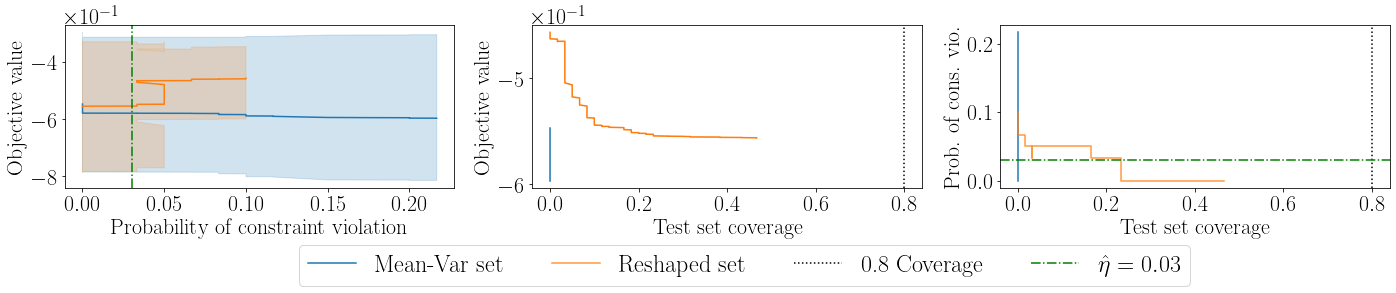

In [13]:
plot_coverage_all(dfgrid,dfgrid2,None, "Portlinear8",ind_1=(0,400),ind_2=(0,400), logscale = False, zoom = False,legend = True)

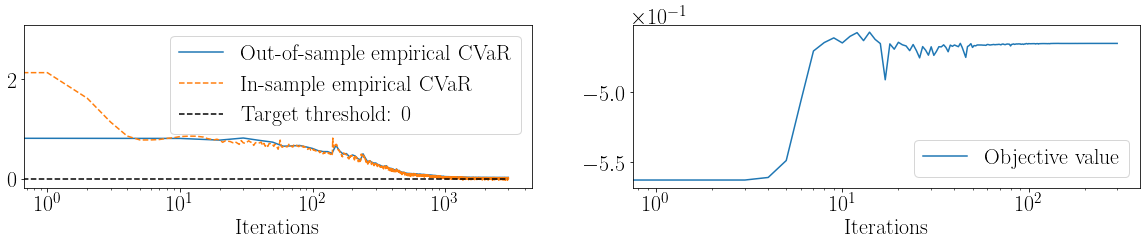

In [14]:
plot_iters(df, result.df_test, "Port", steps = 10000,logscale = 1)

In [9]:
eps_list = np.linspace(0.01, 5, 400)
prob_list = np.array([0.,0.01,0.05,0.1])
# prob_list = np.linspace(0,0.5,10)
inds_standard = []
inds_reshaped = []
for i in prob_list:
    inds_standard.append(np.absolute(np.mean(np.vstack(dfgrid['Probability_violations_test']),axis = 1)-i).argmin())
    inds_reshaped.append(np.absolute(np.mean(np.vstack(dfgrid2['Probability_violations_test']),axis = 1)-i).argmin())
st_eps = eps_list[inds_standard[0]]
re_eps = eps_list[inds_reshaped[0]]
st_eps, re_eps
# A_fin = initn
# b_fin = init_bvaln

(2.2236090225563907, 1.6233082706766917)

In [10]:
x_opt_base = {}
x_opt_learned = {}
t_learned = {}
t_base = {}
test_val_st = []
prob_val_st = []
test_val_re = []
prob_val_re = []
t_re = []
t_st = []
for ind in range(4):
    x_opt_base[ind] = {}
    x_opt_learned[ind] = {}
    t_learned[ind] = {}
    t_base[ind] = {}
    for scene in range(10):
        n = 2
        Amat = (1/eps_list[inds_reshaped[ind]])*A_fin
        bvec = (1/eps_list[inds_reshaped[ind]])*b_fin
        u = lropt.UncertainParameter(n,
                                uncertainty_set=lropt.Ellipsoidal(p=2, a = Amat, b =bvec))
        # Formulate the Robust Problem
        x = cp.Variable(n)
        t = cp.Variable()
        p = cp.Parameter(n)
        p.value = y_data[scene]
        # p1.value = scenarios[0][1]
        objective = cp.Minimize(t + 0.2*cp.norm(x - p,1))

        constraints = [-x@u <= t, cp.sum(x)==1, x >= 0]
        # constraints += [x == x_opt_base[ind][scene]]

        prob = lropt.RobustProblem(objective, constraints)
        prob.solve()
        test_val_re.append(np.mean(-test@x.value) + 0.2*np.linalg.norm(x.value-p.value,1))
        prob_val_re.append(np.sum(np.where(np.maximum(-test@x.value - t.value,0)>= 0.001,1,0))/60)
        # result3.reform_problem.solve()
        x_opt_learned[ind][scene] = x.value
        t_re.append(t.value)
        t_learned[ind][scene] = t.value

        n = 2
        Amat = (1/eps_list[inds_standard[ind]])*init
        bvec = (1/eps_list[inds_standard[ind]])*init_bval
        u = lropt.UncertainParameter(n,
                                uncertainty_set=lropt.Ellipsoidal(p=2,a = Amat, b = bvec))
        # Formulate the Robust Problem
        x = cp.Variable(n)
        t = cp.Variable()
        p = cp.Parameter(n)
        p.value = y_data[scene]
        # p1.value = scenarios[0][1]
        objective = cp.Minimize(t + 0.2*cp.norm(x - p,1))

        constraints = [-x@u <= t, cp.sum(x)==1, x >= 0]

        prob = lropt.RobustProblem(objective, constraints)
        prob.solve()
        test_val_st.append(np.mean(-test@x.value) + 0.2*np.linalg.norm(x.value-p.value,1))
        prob_val_st.append(np.sum(np.where(np.maximum(-test@x.value - t.value,0)>= 0.001,1,0))/60)
        t_st.append(t.value)
        # result3.reform_problem.solve()
        x_opt_base[ind][scene] = x.value
        t_base[ind][scene] = t.value

        x_opt_learned,x_opt_base,t_learned, t_base
    # A_fin, init, b_fin, init_bval
# x_opt_learned,x_opt_base,t_learned, t_base
A_fin, b_fin, init, init_bval

(array([[1.49171516, 0.2131429 ],
        [0.08791244, 1.03750452]]),
 array([-0.05297473,  0.02937576]),
 array([[1.42718702, 0.32670856],
        [0.32670856, 1.75002364]]),
 array([-0.57163764, -0.57724992]))

In [11]:
np.mean(test_val_re[:10]),np.mean(test_val_st[:10])

(-0.20156009738822425, -0.12970749984636717)

In [12]:
K =1
num_p = 50
offset = 2
x_min, x_max = np.min(train[:,0]) - offset, np.max(train[:,0]) + offset
y_min, y_max = np.min(train[:,1]) - offset, np.max(train[:,1]) + offset
X = np.linspace(x_min,x_max,num_p)
Y = np.linspace(y_min,y_max,num_p)
x,y = np.meshgrid(X,Y)
# Z values as a matrix
fin_set = {}
init_set = {}
for ind in range(4):
    fin_set[ind] = {}
    init_set[ind] = {}
    for k_ind in range(K):
        fin_set[ind][k_ind] = np.zeros((num_p,num_p))
        init_set[ind][k_ind] = np.zeros((num_p,num_p))
g_level_learned = {}
g_level_base = {}
for ind in range(4):
    g_level_learned[ind] = {}
    g_level_base[ind] = {}
    for scene in range(10):
        g_level_learned[ind][scene] = np.zeros((num_p,num_p))
        g_level_base[ind][scene] = np.zeros((num_p,num_p))
# init_set = np.zeros((num_p,num_p))
    # Populate Z Values (a 7x7 matrix) - For a circle x^2+y^2=z
    for i in range(num_p):
        for j in range(num_p):
            u_vec = [x[i,j], y[i,j]]
            for k_ind in range(K):
                fin_set[ind][k_ind][i,j] = np.linalg.norm((1/eps_list[inds_reshaped[ind]])*A_fin[k_ind*n:(k_ind+1)*n, 0:n]@ u_vec + (1/eps_list[inds_reshaped[ind]])*b_fin)
                # fin_set[ind][k_ind][i,j] = np.linalg.norm((1/inds_reshaped[ind])*A_fin[k_ind*n:(k_ind+1)*n, 0:n]@ u_vec + (1/inds_reshaped[ind])*b_fin)

            for k_ind in range(K):
                init_set[ind][k_ind][i,j] = np.linalg.norm((1/eps_list[inds_standard[ind]])*init[k_ind*n:(k_ind+1)*n, 0:n]@ u_vec  + (1/eps_list[inds_standard[ind]])*init_bval)
            
            for scene in range(10):
                g_level_learned[ind][scene][i,j] = -x_opt_learned[ind][scene]@u_vec - t_learned[ind][scene]
                g_level_base[ind][scene][i,j] = -x_opt_base[ind][scene]@u_vec - t_base[ind][scene]

In [13]:

def plot_contours_line(x,y,set, g_level,prob_list, num_scenarios,train, title, standard = True):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16, 3.5), constrained_layout= True)
    ax_lst = [ax1, ax2, ax3, ax4]

    cur_ind = 0
    for axis in ax_lst:
        axis.set_title(r'$\hat{\eta}$' + ' = {}'.format(prob_list[cur_ind]))
        axis.set_xlabel(r"$u_1$")
        axis.set_ylabel(r"$u_2$")
        for scene in range(num_scenarios):
            axis.contour(x,y,g_level[cur_ind][scene],[0], colors = ["tab:purple"],alpha = 1,linestyles = ["-"])
        axis.scatter(test[:,0],test[:,1], color = "white",edgecolor = "black")
        axis.scatter(np.mean(test,axis= 0)[0], np.mean(train,axis= 0)[1],color = ["tab:green"])
        for k_ind in range(1):
            axis.contour(x,y,set[cur_ind][k_ind], [1], colors = ["red"],linewidths = [2])
        cur_ind +=1
    if standard:
        post = "Mean-Variance"
    else:
        post = "Reshaped"
    fig.suptitle(post+" set", fontsize = 30)
    plt.savefig(title+"_"+ post + ".pdf", bbox_inches='tight')

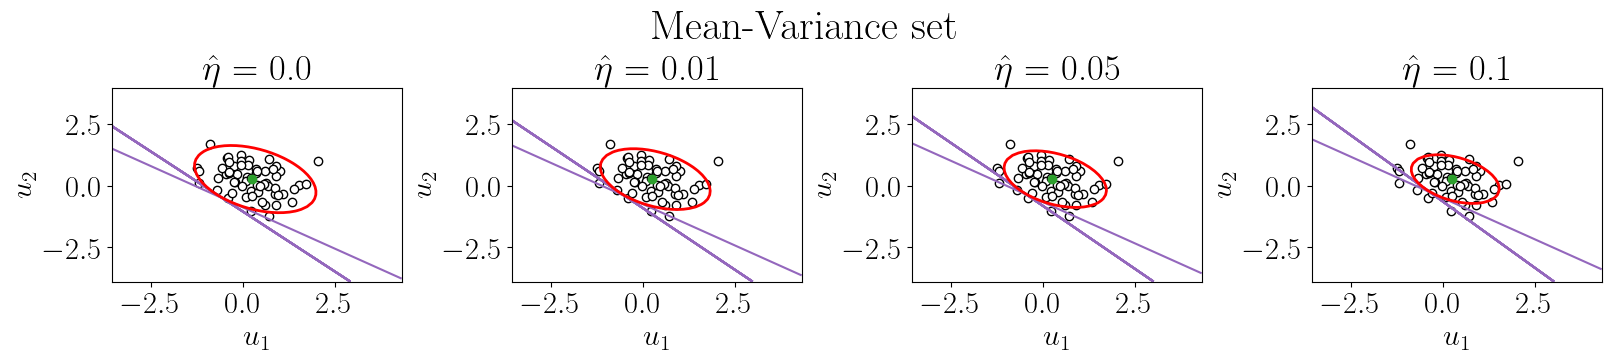

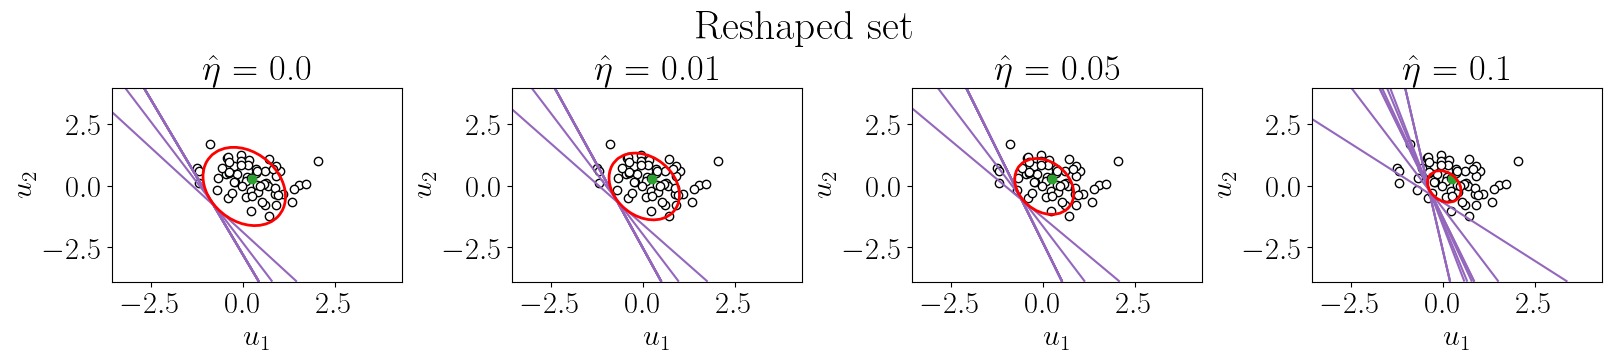

In [14]:
plot_contours_line(x,y,init_set, g_level_base,prob_list,10,train, "port_intro",standard = True) 
plot_contours_line(x,y,fin_set, g_level_learned,prob_list,10,train, "port_intro",standard = False)

### GIF

In [446]:
A_fin = result.A 
b_fin = result.b
A1_iters, b1_iters = result.uncset_iters

def port_prob(A_final, b_final, scene):
    n = 2
    u = lropt.UncertainParameter(n,
                                uncertainty_set=lropt.Ellipsoidal(p=2, A = A_final, b =b_final))
    # Formulate the Robust Problem
    x = cp.Variable(n)
    t = cp.Variable()
    p = cp.Parameter(n)
    p.value = scenarios[scene][0]
    # p1.value = scenarios[0][1]
    objective = cp.Minimize(t + 0.2*cp.norm(x - p,1))

    constraints = [-x@u <= t, cp.sum(x)==1, x >= 0]
    # constraints += [x == x_opt_base[ind][scene]]

    prob = lropt.RobustProblem(objective, constraints)
    prob.solve()
    t_opt = t.value
    x_opt = x.value
    return x_opt, t_opt

offset = 1
x_min, x_max = np.min(train[:,0]) - 3*offset, np.max(train[:,0]) + offset
y_min, y_max = np.min(train[:,1]) - offset, np.max(train[:,1]) + offset
n_points = 100
X = np.linspace(x_min,x_max,n_points)
Y = np.linspace(y_min,y_max,n_points)
x_mesh,y_mesh = np.meshgrid(X,Y)

def optimal_sols(A_final, b_final, num_scenarios):
    x_opt = {}
    t_opt = {}
    for scene in range(num_scenarios):
        x_opt[scene], t_opt[scene] = port_prob(A_final, b_final, scene)
    return x_opt, t_opt

def level_set(A_final, b_final, offset = 2, n = n_points, x_mesh = x_mesh, y_mesh = y_mesh):
    unc_level_set = np.zeros((n,n))
    g_level_set = np.zeros((num_scenarios,n,n))
    x_opt,t_opt = optimal_sols(A_final, b_final, num_scenarios)
    for i in range(n):
        for j in range(n):
            u_vec = [x_mesh[i,j], y_mesh[i,j]]
            unc_level_set[i,j] = np.linalg.norm(A_final @ u_vec  + b_final)
            for scene in range(num_scenarios):
                g_level_set[scene,i,j] = -x_opt[scene]@u_vec - t_opt[scene]

    return unc_level_set, g_level_set

unc_level_learned, g_level_learned = level_set(A_fin/re_eps, b_fin/re_eps)
unc_level, g_level = level_set(A1_iters[0], b1_iters[0])
unc_level_base, g_level_base = level_set(init/st_eps, init_bval/st_eps)

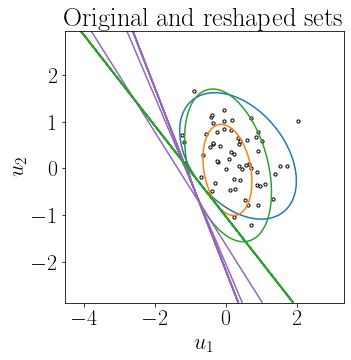

In [447]:
plt.figure(figsize=(5, 5))
plt.title("Original and reshaped sets")
# Set axis label for the contour plot
plt.xlabel(r"$u_1$")
plt.ylabel(r"$u_2$")

plt.contour(x_mesh,y_mesh,unc_level_base, [1], colors = ["tab:blue"], label = "Initial Set")
plt.contour(x_mesh,y_mesh,unc_level_learned, [1], colors = ["tab:green"], label = "Final Set")
plt.contour(x_mesh,y_mesh,unc_level, [1], colors = ["tab:orange"], label = "Final Set")
for scene in range(num_scenarios):
    plt.contour(x_mesh,y_mesh,g_level_learned[scene,:,:], [0], colors = ["tab:purple"], label = "Initial Set")
    plt.contour(x_mesh,y_mesh,g_level_base[scene,:,:], [0], colors = ["tab:green"], label = "Final Set")

plt.scatter(test[:,0],test[:,1], color = "white",edgecolors= "black", s = 10)
# plt.savefig("Reshaped_ctrs.pdf", bbox_inches='tight')
plt.show()

In [449]:
import os
import imageio

filenames = []
eps_train = np.linspace(1,re_eps, 20)
for i in range(40):
    # 
    if i < 10:
        unc_level, g_level = level_set(A1_iters[i], b1_iters[i])
    elif i < 20:
        unc_level, g_level = level_set(A1_iters[10+9*(i-10)], b1_iters[10+9*(i-10)])
    else:
        unc_level, g_level = level_set(A1_iters[99]/eps_train[i-20], b1_iters[99]/eps_train[i-20])
    plt.figure(figsize=(5, 5))
    # plt.title("Original and reshaped sets")
    # Set axis label for the contour plot
    # plt.xlabel(r"$u_1$")
    # plt.ylabel(r"$u_2$")

    plt.contour(x_mesh,y_mesh,unc_level_base, [1], colors = ["tab:blue"], label = "Initial Set")
    plt.contour(x_mesh,y_mesh,unc_level, [1], colors = ["tab:red"], label = "trained Set")
    plt.contour(x_mesh,y_mesh,unc_level_learned, [1], colors = ["tab:green"], label = "Final Set")
    for scene in range(num_scenarios):
        plt.contour(x_mesh,y_mesh,g_level[scene,:,:], [0], colors = ["tab:purple"], label = "Initial Set")

    filename = f'gif_images/{i}.png'
    filenames.append(filename)

    plt.scatter(test[:,0],test[:,1], color = "white",edgecolors= "black", s = 10)
    plt.savefig(filename)
    plt.close()

with imageio.get_writer('gifs/portfolio.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

In [6]:
beg1, end1 = 0, 500
beg2, end2 = 0, 500
plt.figure(figsize=(15, 5))
plt.plot(np.mean(np.vstack(dfgrid['Violations']), axis=1)[beg1:end1], np.mean(np.vstack(
    dfgrid['Test_val']), axis=1)[beg1:end1], color="tab:blue", label=r"Mean-Var set", marker="v", zorder=0)
plt.fill(np.append(np.quantile(np.vstack(dfgrid['Violations']), 0.25, axis=1)[beg1:end1], np.quantile(np.vstack(dfgrid['Violations']), 0.75, axis=1)[beg1:end1][::-1]), np.append(
    np.quantile(np.vstack(dfgrid['Test_val']), 0.25, axis=1)[beg1:end1], np.quantile(np.vstack(dfgrid['Test_val']), 0.75, axis=1)[beg1:end1][::-1]), color="tab:blue", alpha=0.2)
for ind in range(4):
    plt.scatter(np.mean(np.vstack(dfgrid['Violations']), axis=1)[inds_standard[ind]], np.mean(np.vstack(
        dfgrid['Test_val']), axis=1)[inds_standard[ind]], color="tab:green", s=50, marker="v", zorder=10)
plt.plot(np.mean(np.vstack(dfgrid2['Violations']), axis=1)[beg2:end2], np.mean(np.vstack(
    dfgrid2['Test_val']), axis=1)[beg2:end2], color="tab:orange", label="Reshaped set", marker="^", zorder=1)
plt.fill(np.append(np.quantile(np.vstack(dfgrid2['Violations']), 0.25, axis=1)[beg2:end2], np.quantile(np.vstack(dfgrid2['Violations']), 0.75, axis=1)[beg2:end2][::-1]), np.append(
    np.quantile(np.vstack(dfgrid2['Test_val']), 0.25, axis=1)[beg2:end2], np.quantile(np.vstack(dfgrid2['Test_val']), 0.75, axis=1)[beg2:end2][::-1]), color="tab:orange", alpha=0.2)
for ind in [0, 2, 1, 3]:
    plt.scatter(np.mean(np.vstack(dfgrid2['Violations']), axis=1)[inds_reshaped[ind]], np.mean(
        np.vstack(dfgrid2['Test_val']), axis=1)[inds_reshaped[ind]], color="black", s=50, marker="^")
plt.ylabel("Objective value")
# ax2.set_xlim([-1,20])
plt.xlabel(r"Probability of constraint violation $(\hat{\eta})$")
# plt.xscale("log")
# plt.ylim([-3, 1])
plt.vlines(ymin=-0.3, ymax=-0, x=prob_list[0], linestyles=":",
           color="tab:red", label="Reference $\hat{\eta}$")
for i in prob_list[1:]:
    plt.vlines(ymin=-0.3, ymax=0, x=i, linestyles=":", color="tab:red")
plt.legend()
plt.savefig("portlinear_objective_vs_violations.pdf", bbox_inches='tight')

KeyError: 'Violations'

<Figure size 1500x500 with 0 Axes>

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(prob_val_st,test_val_st, marker = "^", label = "Identity set out-of-sample")
plt.plot(prob_val_st,t_st, label = "Identity set in-sample")
plt.plot(prob_val_re,test_val_re,marker= "v", label = "Random set out-of-sample")
plt.plot(prob_val_re,t_re, label = "Random set in-sample")
plt.ylabel("Objective value")
plt.xlabel(r"Probability of constraint violation $(\hat{\eta})$")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(prob_val_st,test_val_st, marker = "^", label = "Identity set out-of-sample")
plt.plot(prob_val_st,t_st, label = "Identity set in-sample")
plt.plot(prob_val_re,test_val_re,marker= "v", label = "Random set out-of-sample")
plt.plot(prob_val_re,t_re, label = "Random set in-sample")
plt.ylabel("Objective value")
plt.xlabel(r"Probability of constraint violation $(\hat{\eta})$")
plt.legend()
plt.show()